<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/vapnik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None or len(conts)<2:
            #conts = list(classes)
            vmin,vmax = classes[0]-eps,classes[-1]+eps
        else:            
            vmin,vmax= np.min(conts)-eps,np.max(conts)+eps
        
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None or len(conts)<2:            
            conts = sorted([-1+eps,0,1-eps])
        else:
            vmin,vmax= np.min(conts)-eps,np.max(conts)+eps
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)
        
        z = np.reshape(z,(npts,npts)).T        
        
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)
    
    if Y is not None:        
        for i,y in enumerate(classes):
            
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 50)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()
    return extent

<ipython-input-7-825a4cf92d43>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wb = torch.tensor(wb,requires_grad=True)
<ipython-input-1-ec5585c83180>:63: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


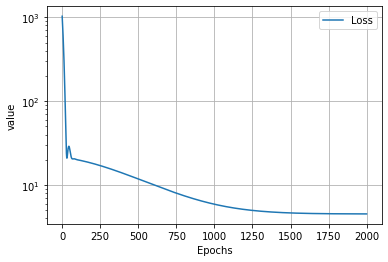

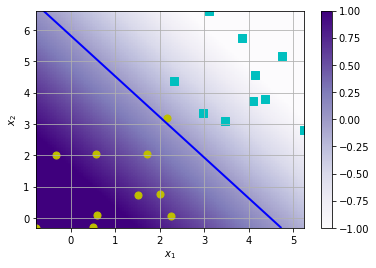

[-0.7743650262301195,
 5.247385094025316,
 -0.31542097900216387,
 6.618390874023395]

In [7]:
"""
Author: Fayyaz Minhas
"""
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.modules as nn
import torch.optim as optim
from sklearn.datasets import make_moons, make_circles;  
#Let's generate some data

#X,y = make_circles(n_samples=800,  shuffle=True, noise=0.05, random_state=None, factor = 0.5)
#Xp = X[y==1]; Xn = X[y!=1]
Xp = 1.0+np.random.randn(10,2); Xn = 4+np.random.randn(10,2);
inputs = np.vstack((Xp,Xn))	
#labels
targets = np.hstack((np.ones(len(Xp)),-np.ones(len(Xn))))
ttargets = targets+0 #copy of true labels
 
from sklearn.metrics.pairwise import rbf_kernel
#K = (np.dot(inputs,inputs.T)+1)**2
K = rbf_kernel(inputs,gamma=2.0)
K = torch.from_numpy(K).float() #kernel
P = 1.0
device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
x = torch.from_numpy(inputs).float()
y = torch.from_numpy(targets).float()
N, D_in,D_out = x.shape[0], x.shape[1], 1

learning_rate = 1e-2


uidx, pidx, nidx = torch.isnan(y), y==1, y==-1
n_unsupv, n_pos, n_neg = torch.sum(uidx), torch.sum(pidx), torch.sum(nidx)
lower, upper = -(1.0 / np.sqrt(D_in)), (1.0 / np.sqrt(N)) #xavier weight init
wb = lower + torch.rand(D_in) * (upper - lower)
wb = torch.tensor(wb,requires_grad=True)
bb = torch.tensor(0.0,requires_grad=True)
optimizer = optim.Adam([wb,bb], lr=learning_rate)
L = [] #history of losses
for epoch in range(2000):
      """
      # REPRESENTATION
      """
      y_pred = x@wb+bb
      # Evaluation   
      obj = (y-y_pred)@(K+P)@(y-y_pred)

      """
      #OPTIMIZATION
      """    
      obj.backward()
      # Using built-in optimizer
      optimizer.step()
      optimizer.zero_grad()
      L.append(obj.detach().numpy()) #save for history and plotting

wbn = wb.detach().numpy()
bbn = bb.detach().numpy()

#plt.close("all")
plt.figure()
plt.plot(L);plt.yscale('log')

plt.grid(); plt.xlabel('Epochs'); plt.ylabel('value');plt.legend(['Loss','Objective'])

def clf(inputs): 
  return inputs@wbn+bbn

plt.figure()
plotit(inputs,targets,clf=clf,conts=[0])


In [8]:
y_pred = x@wb+bb#wb@K
#berr = torch.mean(y_pred[uidx])-cratio
berr = 0.0
z = (y_pred-berr).detach().numpy()
print("Accuracy",np.mean(z*ttargets>0))
from sklearn.metrics import roc_auc_score
print("AUROC",roc_auc_score(ttargets, z))
#print("AUROC",roc_auc_score(ttargets, wbn))

Accuracy 0.95
AUROC 1.0
